# Importing relevant modules

In [165]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Loading dataset

In [166]:
df = pd.read_csv('saveecobot_4230.csv')
df = df.drop(['value_text'], axis=1)
df.head()

,device_id,phenomenon,value,logged_at
0,4230,aqi,65.0,2020-08-11 23:00:00
1,4230,pm25,18.6,2020-08-11 23:00:00
2,4230,temperature,19.0,2020-08-11 23:00:00
3,4230,humidity,88.0,2020-08-11 23:00:00
4,4230,pressure_pa,101500.0,2020-08-11 23:00:00


# Exploration Data Analysis

In [167]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124610 entries, 0 to 124609
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   device_id   124610 non-null  int64  
 1   phenomenon  124610 non-null  object 
 2   value       124610 non-null  float64
 3   logged_at   124610 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 3.8+ MB


In [168]:
df.describe()

,device_id,value
count,124610.0,124610.000000
mean,4230.0,20351.991925
std,0.0,40626.486865
min,4230.0,-21.000000
25%,4230.0,13.000000
50%,4230.0,47.000000
75%,4230.0,93.000000
max,4230.0,104800.000000


## Cheking for missing values

In [169]:
df.isnull().sum()

device_id     0
phenomenon    0
value         0
logged_at     0
dtype: int64

In [170]:
(df['value'] == 0).sum()

2397

In [171]:
print(f'Percentage of "0" entries: {round((df["value"] == 0).sum()/len(df) * 100, 3)} %')

Percentage of "0" entries: 1.924 %


Since the amount of such values are insignificant it's save to delete them.

In [172]:
df = df[df['value'] != 0]

## Transform dates

In [173]:
df['logged_at'] = pd.to_datetime(df['logged_at'])
df

,device_id,phenomenon,value,logged_at
0,4230,aqi,65.0,2020-08-11 23:00:00
1,4230,pm25,18.6,2020-08-11 23:00:00
2,4230,temperature,19.0,2020-08-11 23:00:00
3,4230,humidity,88.0,2020-08-11 23:00:00
4,4230,pressure_pa,101500.0,2020-08-11 23:00:00
...,...,...,...,...
124605,4230,aqi,12.0,2023-09-05 17:00:00
124606,4230,pm25,3.0,2023-09-05 17:00:00
124607,4230,temperature,24.0,2023-09-05 17:00:00
124608,4230,humidity,43.0,2023-09-05 17:00:00


Since the values for pressure_pa are much higher than the other values in phenomenon column, It would make sense to split the data.

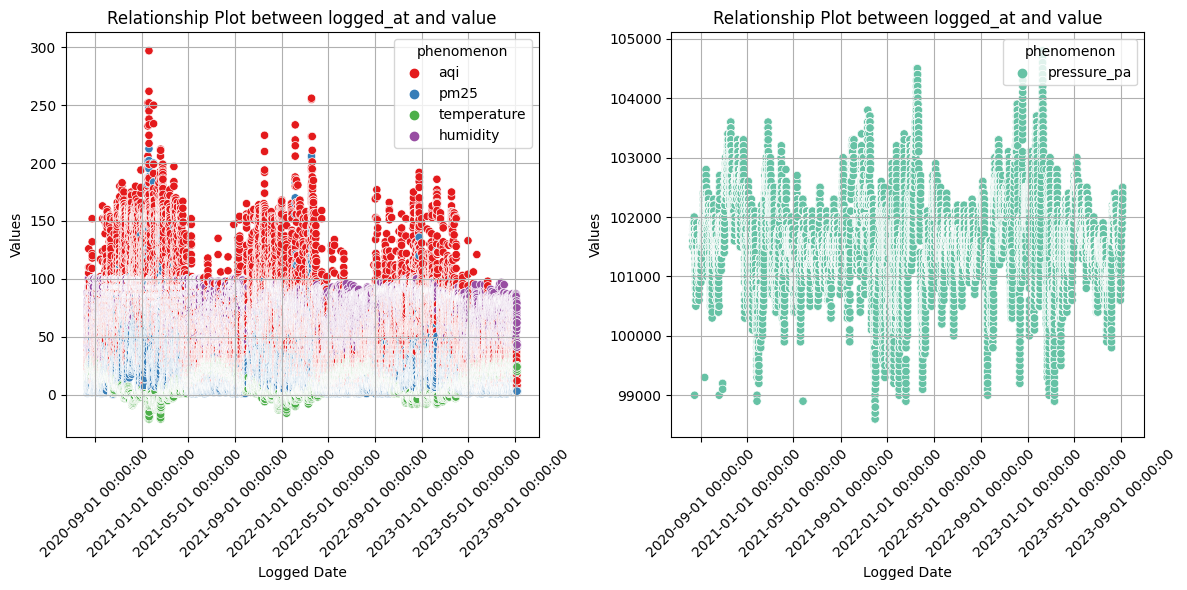

In [174]:
plt.figure(figsize=(12, 6))

# Create a scatter plot with hue for 'phenomenal' column
plt.subplot(1, 2, 1)
sns.scatterplot(x=df['logged_at'], y=df[df['phenomenon'] != 'pressure_pa']['value'], hue=df[df['phenomenon'] != 'pressure_pa']['phenomenon'], marker='o', palette='Set1')
plt.xlabel('Logged Date')
plt.ylabel('Values')
plt.title('Relationship Plot between logged_at and value')
plt.grid(True)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.xticks(rotation=45)

# Create a scatter plot with hue for 'phenomenal' column
plt.subplot(1, 2, 2)
sns.scatterplot(x=df['logged_at'], y=df[df['phenomenon'] == 'pressure_pa']['value'], hue=df[df['phenomenon'] == 'pressure_pa']['phenomenon'], marker='o', palette='Set2')
plt.xlabel('Logged Date')
plt.ylabel('Values')
plt.title('Relationship Plot between logged_at and value')
plt.grid(True)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.xticks(rotation=45)

# Show legend
plt.legend(title='phenomenon', loc='upper right')

# Display the plot
plt.tight_layout()
plt.show()

Too analize these plots futher, data need to be group by year and phenomenon.

In [175]:
df['logged_at'] = pd.to_datetime(df['logged_at'])

In [176]:
phenomenons = list(df['phenomenon'].unique())
colors = ['lightcoral', 'palegreen', 'lightblue', 'plum', 'lightpink']
df['logged_at'] = pd.to_datetime(df['logged_at'])

In [177]:
yearly_phenomenon_groups = df.groupby([df['logged_at'].dt.year, 'phenomenon'])

aqi


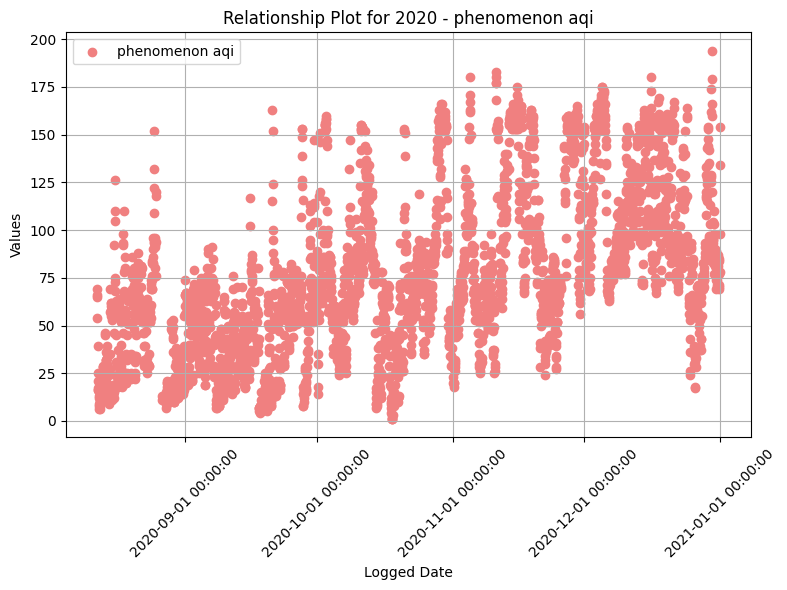

humidity


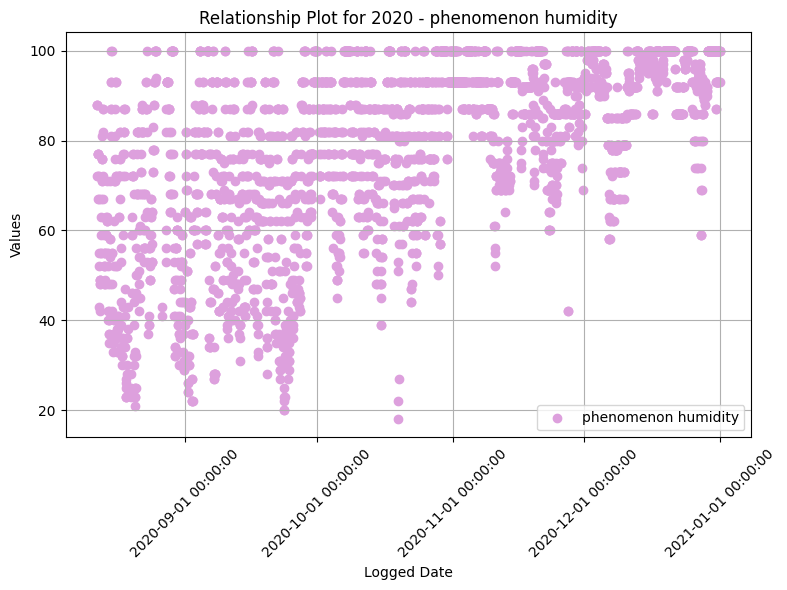

pm25


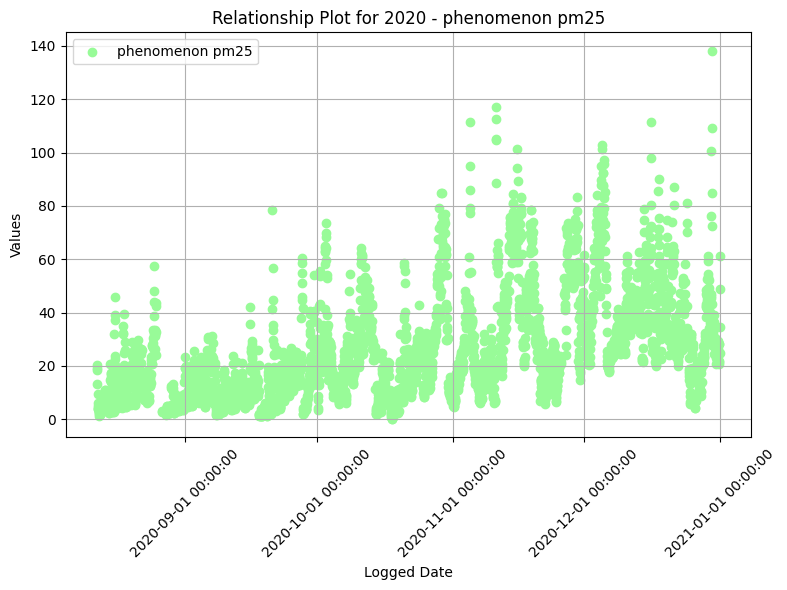

pressure_pa


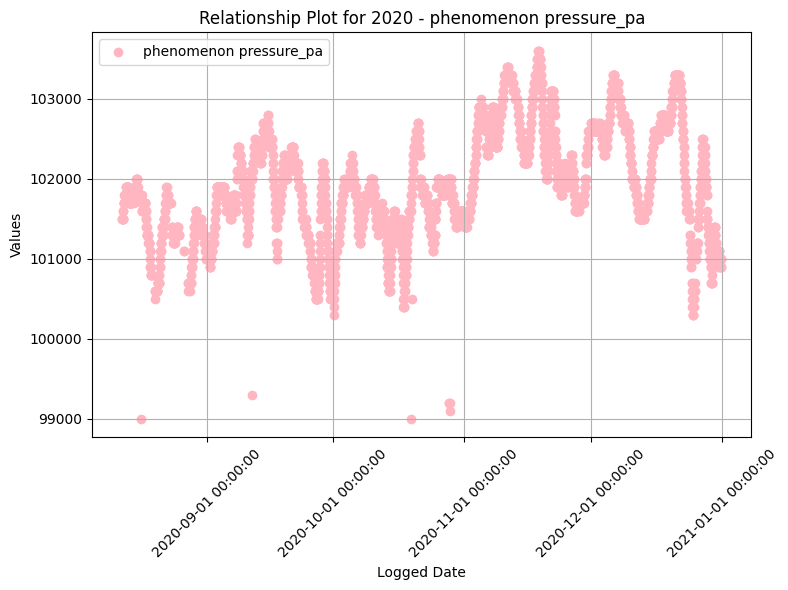

temperature


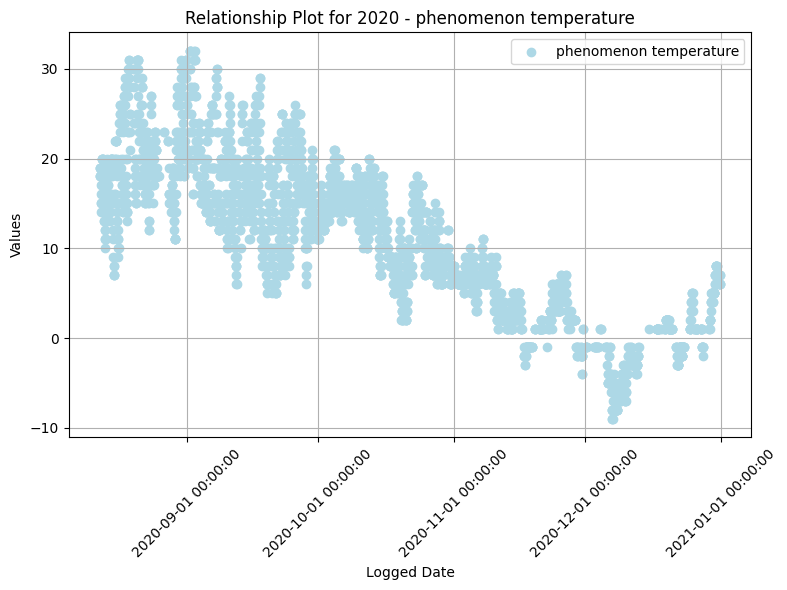

aqi


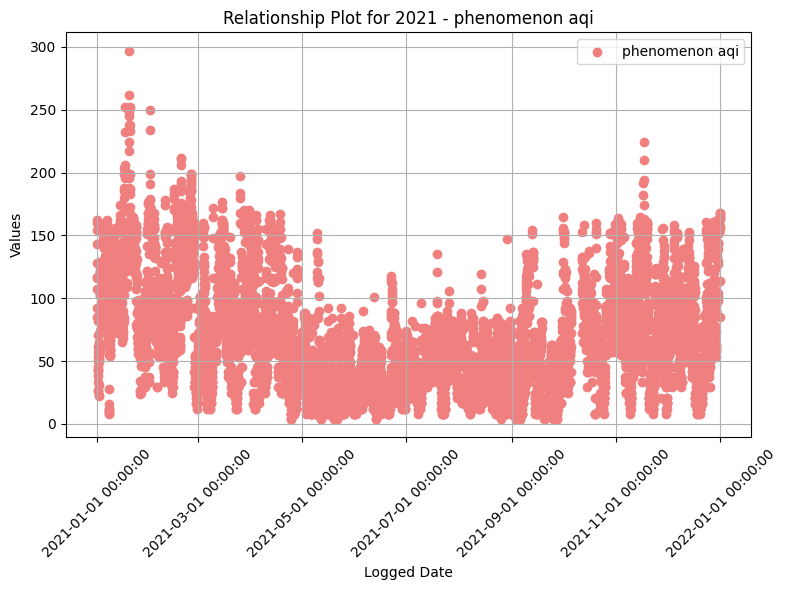

humidity


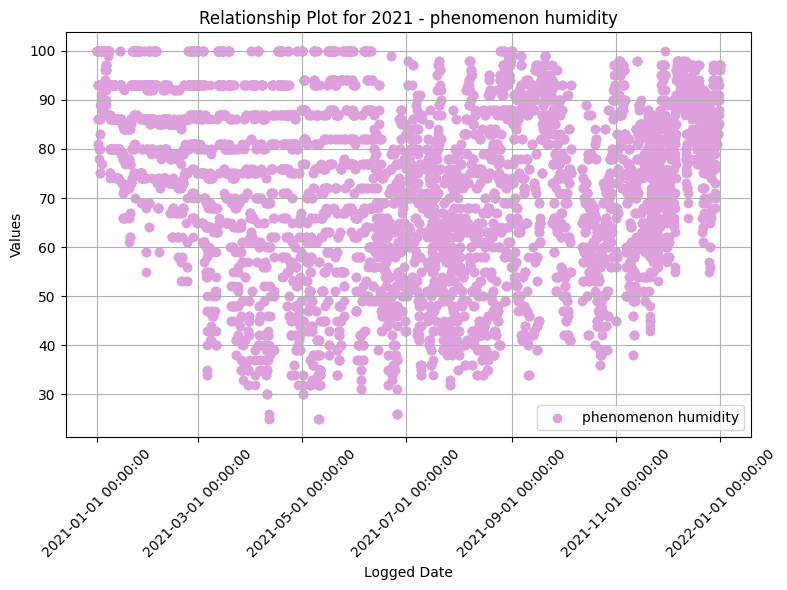

pm25


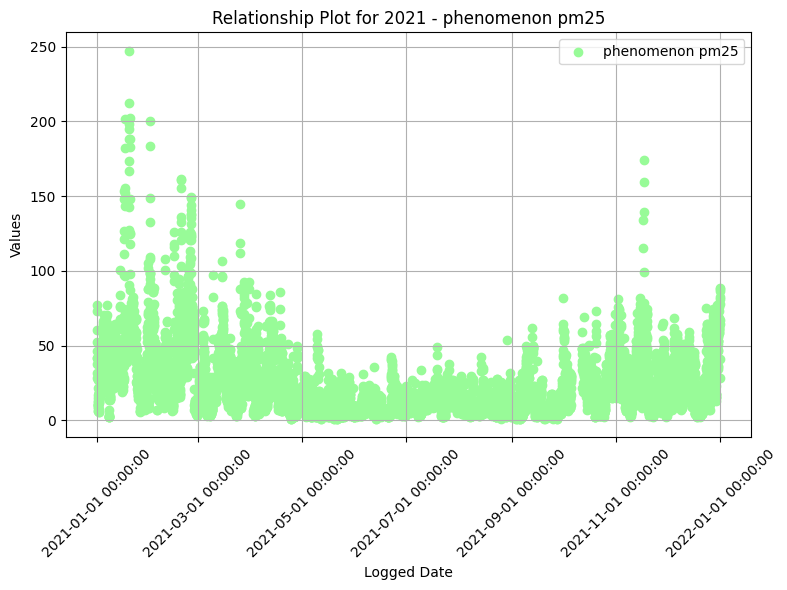

pressure_pa


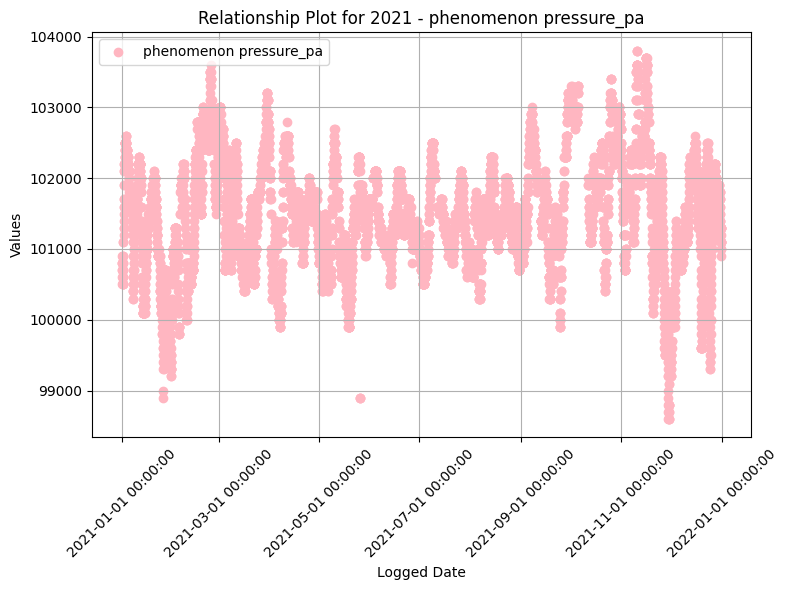

temperature


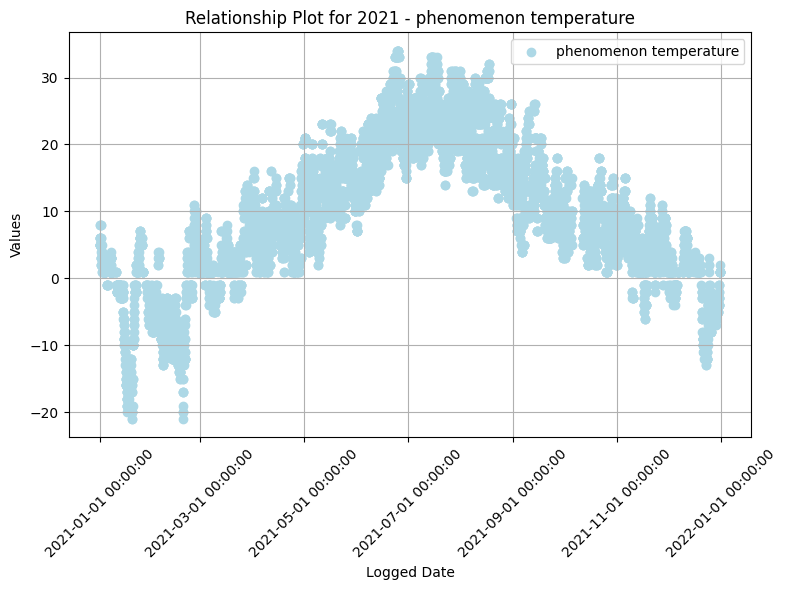

aqi


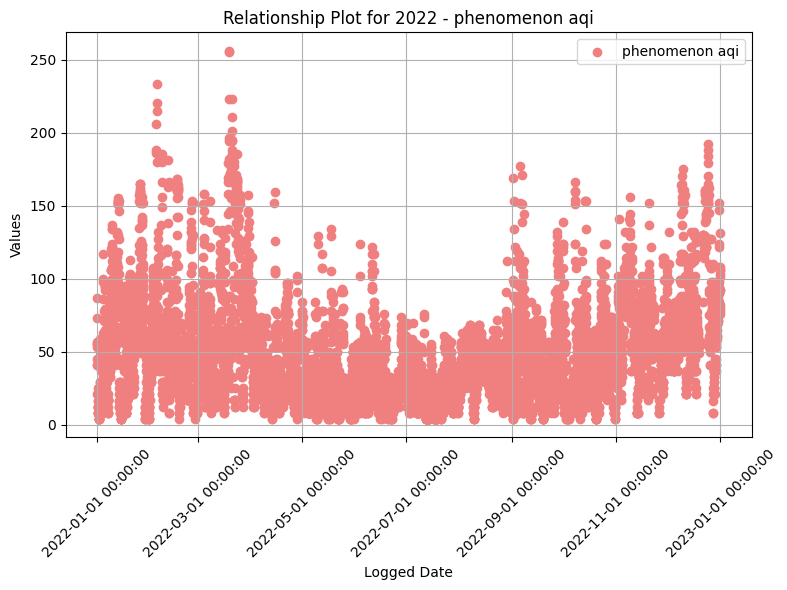

humidity


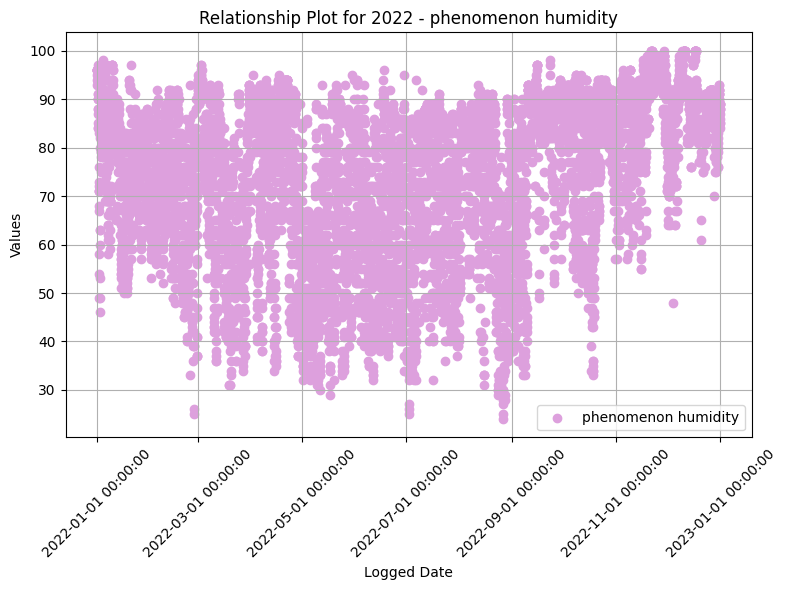

pm25


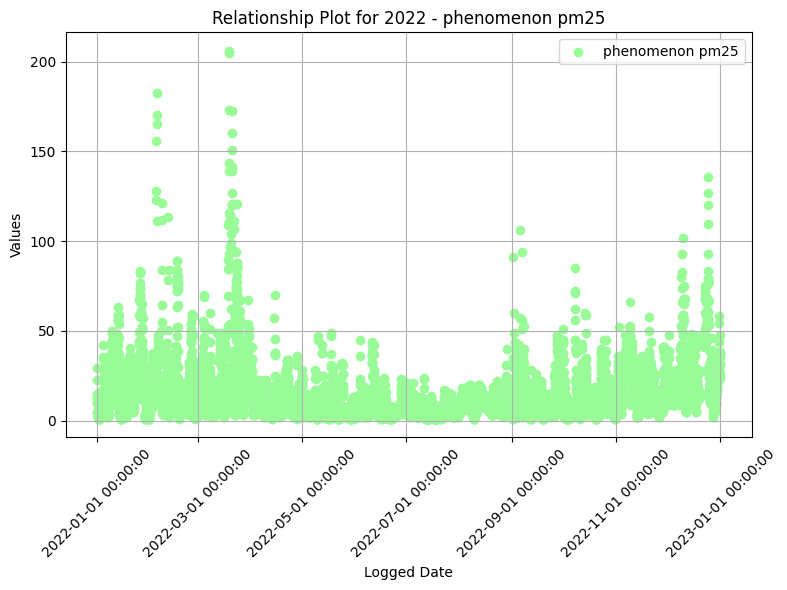

pressure_pa


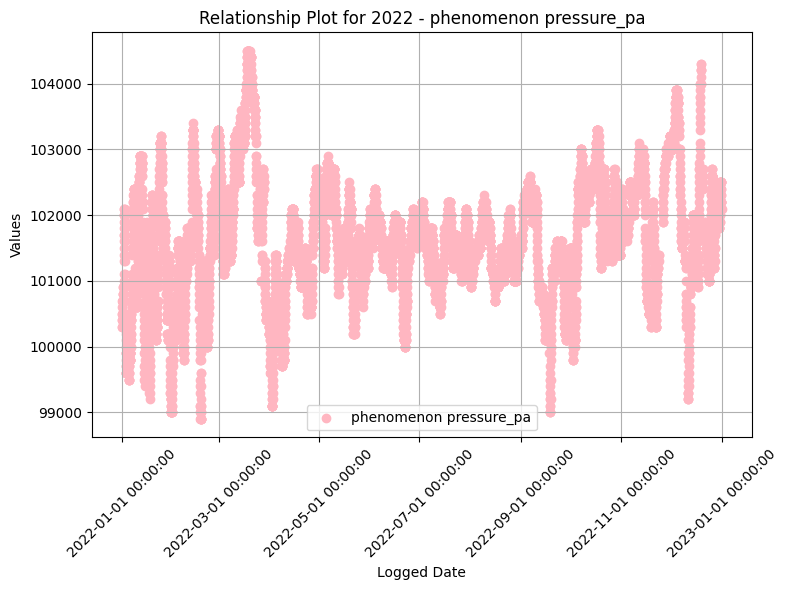

temperature


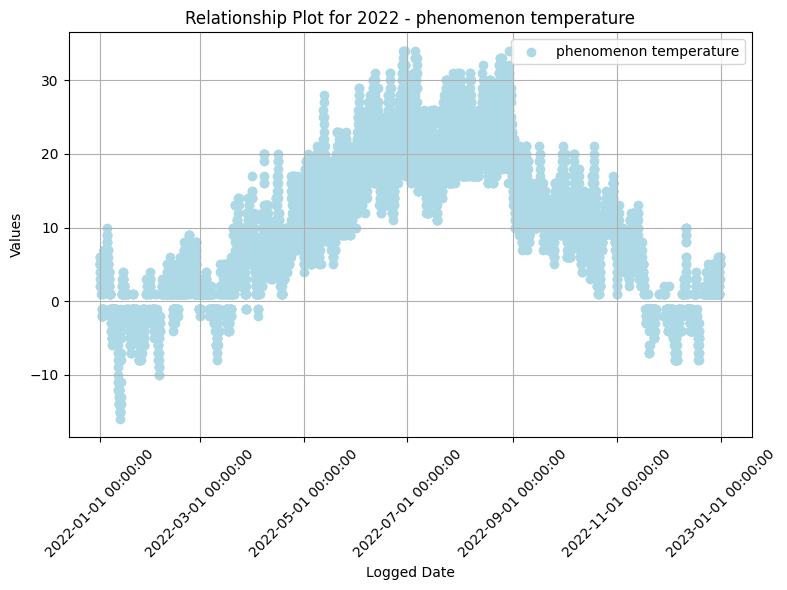

aqi


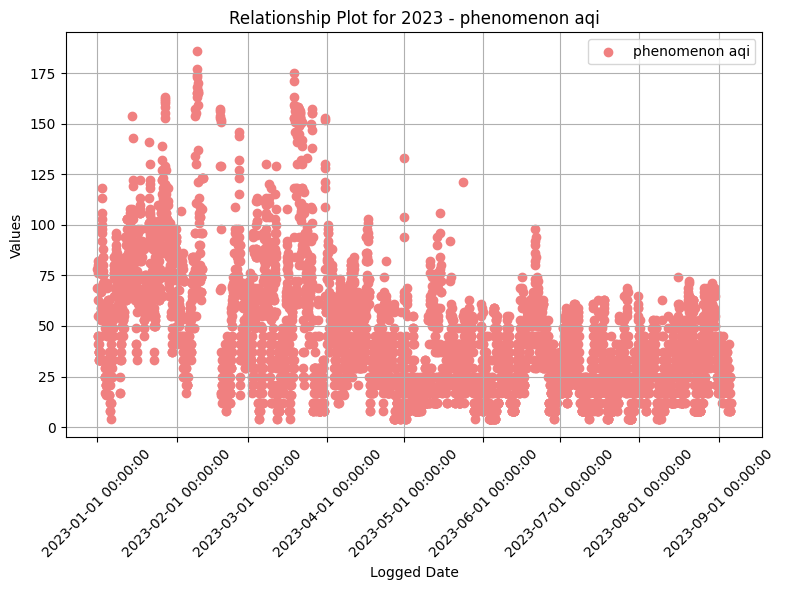

humidity


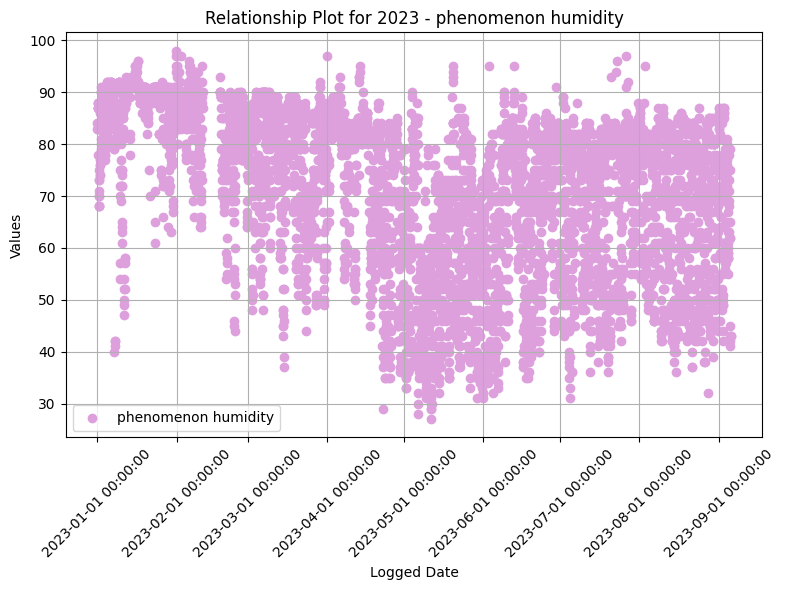

pm25


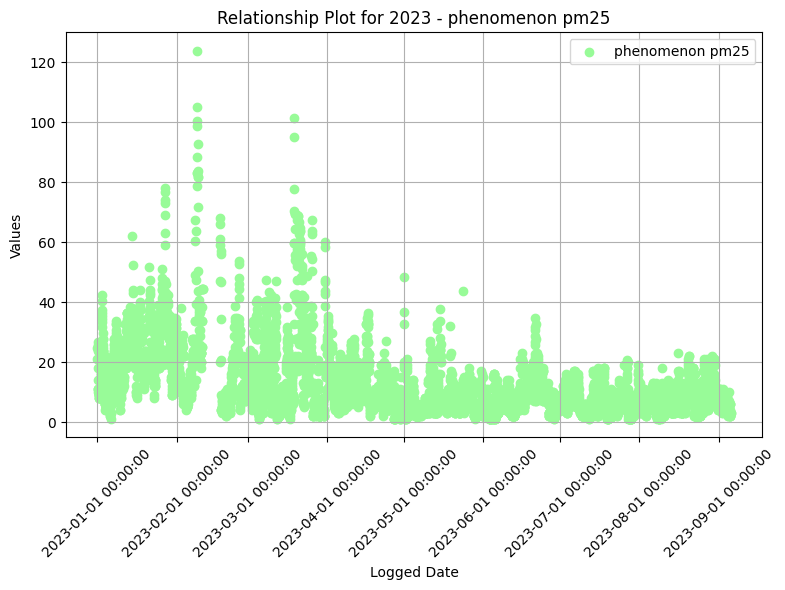

pressure_pa


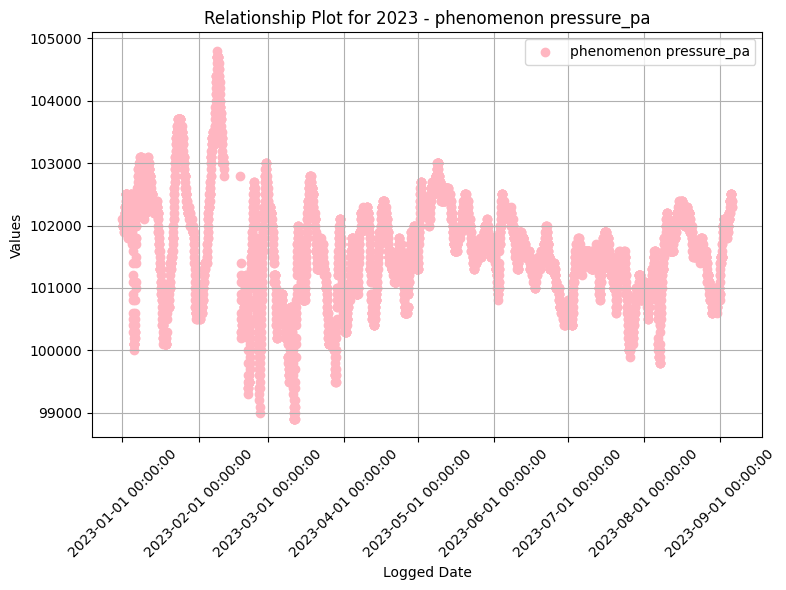

temperature


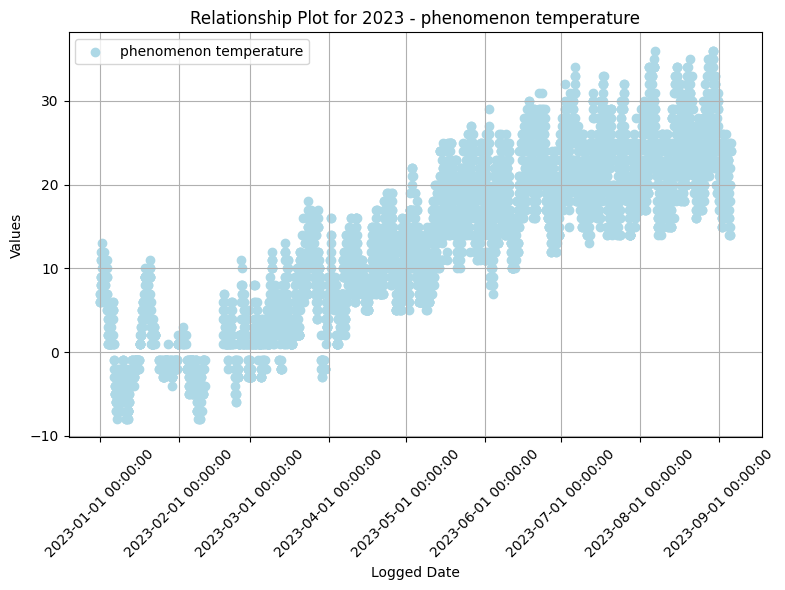

In [178]:



for (year, phenomenon), group in yearly_phenomenon_groups:
    print(phenomenon)
    plt.figure(figsize=(8, 6))
    plt.scatter(group['logged_at'], group['value'], marker='o', label=f'phenomenon {phenomenon}', color=colors[phenomenons.index(phenomenon) % len(colors)])
    plt.xlabel('Logged Date')
    plt.ylabel('Values')
    plt.title(f'Relationship Plot for {year} - phenomenon {phenomenon}')
    plt.grid(True)
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d %H:%M:%S'))
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

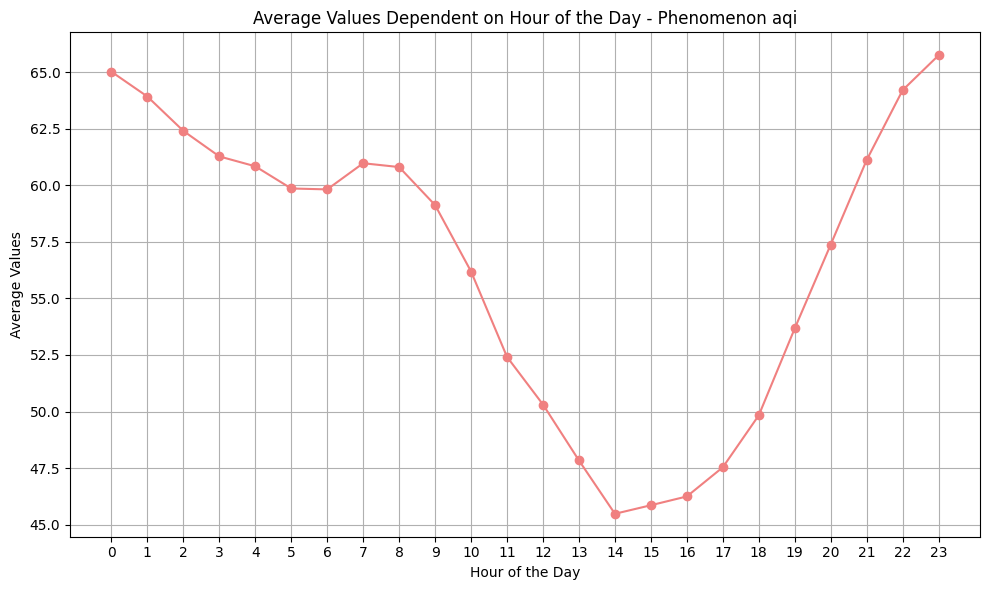

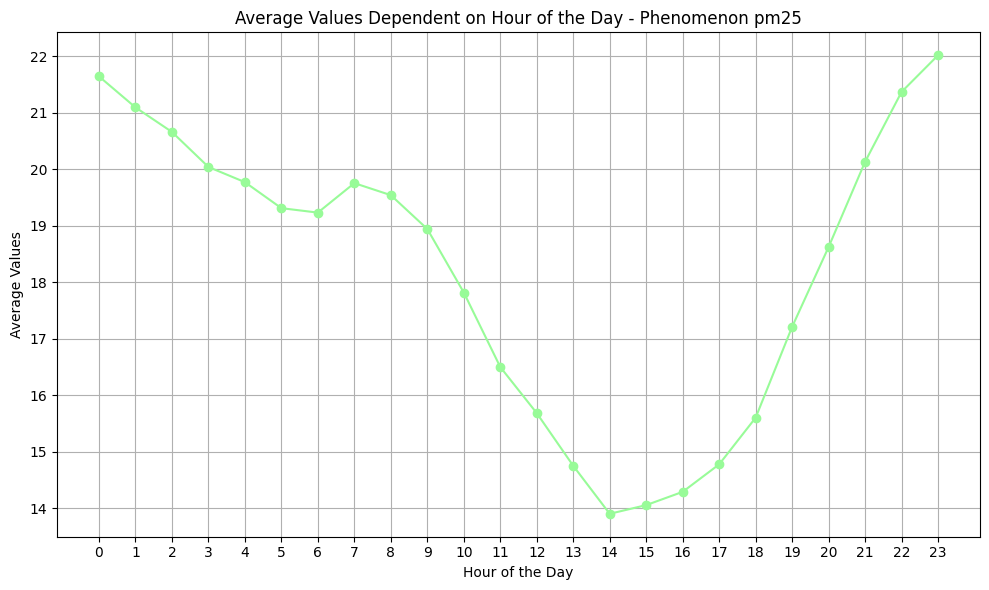

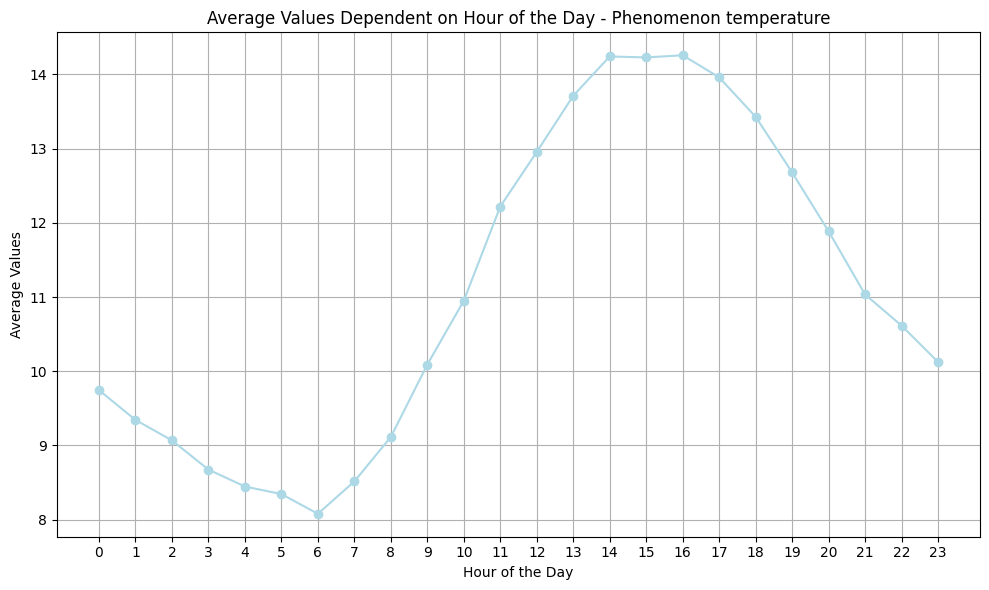

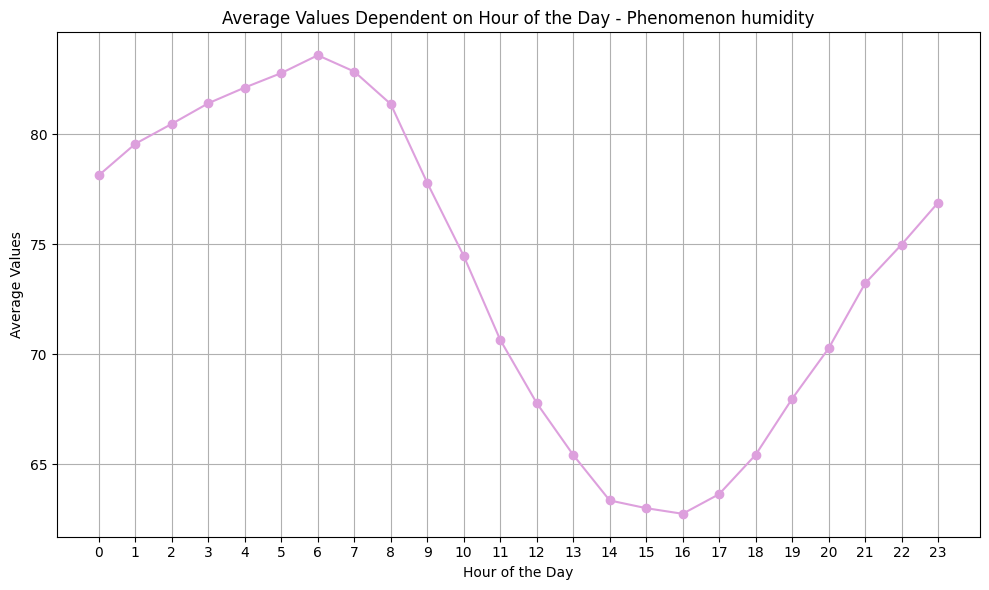

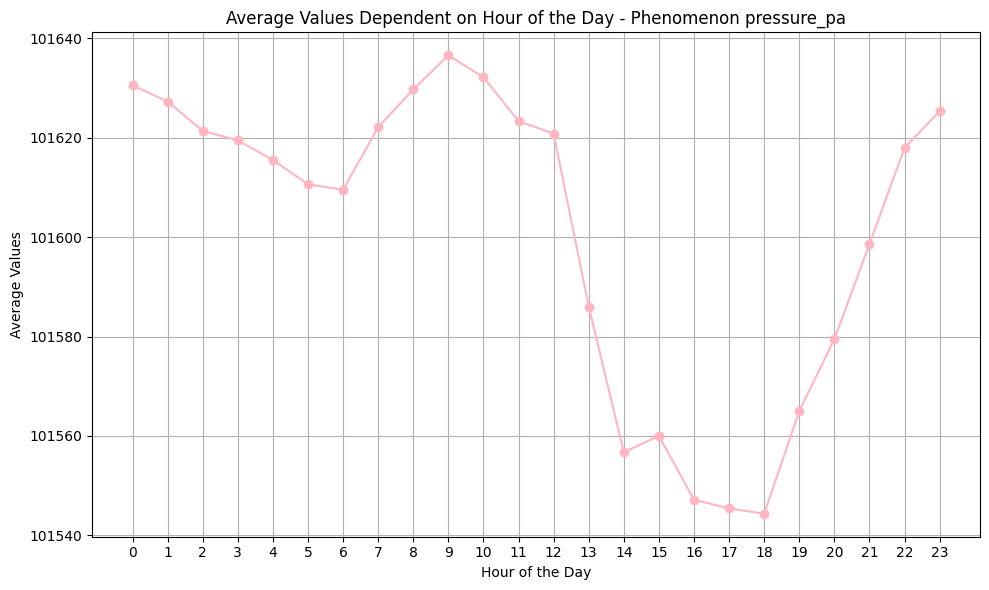

In [179]:

df['hour'] = df['logged_at'].dt.hour
average_values = df.groupby(['phenomenon', 'hour'])['value'].mean().reset_index()

for phenomenon_category in phenomenons:
    plt.figure(figsize=(10, 6))
    subset_df = average_values[average_values['phenomenon'] == phenomenon_category]
    plt.plot(subset_df['hour'], subset_df['value'], marker='o', color=colors[phenomenons.index(phenomenon_category) % len(colors)])
    plt.xlabel('Hour of the Day')
    plt.ylabel('Average Values')
    plt.title(f'Average Values Dependent on Hour of the Day - Phenomenon {phenomenon_category}')
    plt.grid(True)
    plt.xticks(range(24))  
    plt.tight_layout()
    plt.show()